# Classification metrics

In this notebook, we analyze classification metrics for the binary case.

Let's load libraries and define the metrics.

In [1]:
using EvalMetrics: @metric, apply
using EvalMetrics
using Gadfly
using Printf

In [15]:
N_DATA = 1000

@metric Informedness
@metric Markedness

EvalMetrics.apply(::Type{Informedness}, x::ConfusionMatrix) = x.tp/x.p - x.fp/x.n
EvalMetrics.apply(::Type{Markedness}, x::ConfusionMatrix) = x.tp/(x.tp + x.fn) - x.fn/(x.tn + x.fp)

METRICS = [prevalence, true_positive_rate, true_negative_rate, accuracy, balanced_accuracy, f1_score, mcc, informedness, markedness]

9-element Vector{Function}:
 prevalence (generic function with 1 method)
 true_positive_rate (generic function with 1 method)
 true_negative_rate (generic function with 1 method)
 accuracy (generic function with 1 method)
 balanced_accuracy (generic function with 1 method)
 f1_score (generic function with 1 method)
 matthews_correlation_coefficient (generic function with 1 method)
 informedness (generic function with 1 method)
 markedness (generic function with 1 method)

Now, let's create a few confusion matrices. We will create matrices based on the unbalance of the real classes and of the predicted classes.

In [91]:
function make_cms(range)
    cms = Vector{ConfusionMatrix{Int64}}(undef, 0)
    for unbalance in range
        for unbalance_p in range
            for unbalance_n in range
                data_p = round(Int64, N_DATA * unbalance)
                data_n = round(Int64, N_DATA * (1 - unbalance))
                tp = min(N_DATA-1, max(1, round(Int64, unbalance_p * data_p)))
                fn = min(N_DATA-1, max(1, round(Int64, (1-unbalance_p) * data_p)))
                tn = min(N_DATA-1, max(1, round(Int64, unbalance_n * data_n)))
                fp = min(N_DATA-1, max(1, round(Int64, (1-unbalance_n) * data_n)))
                push!(cms, ConfusionMatrix(data_p, data_n, tp, tn, fp, fn))
            end
        end
    end
    return cms
end

cms = make_cms(0.1:0.2:0.9);

Now, let's compute the metrics for each confusion matrix and plot the results

In [89]:
function compute_metrics(cms)
    metrics = Dict{String, Vector{Float64}}()
    for m in METRICS
        metrics[string(m)] = Vector{Float64}(undef, 0)
    end
    for cm in cms
        for m in METRICS
            push!(metrics[string(m)], m(cm))
        end
    end
    return metrics
end
metrics = compute_metrics(cms)
set_default_plot_size(36cm, 24cm)

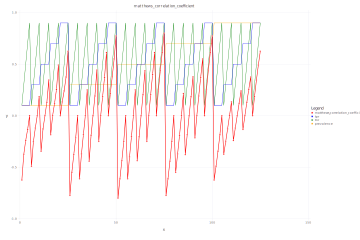

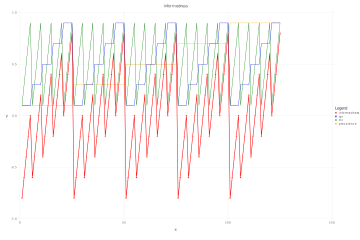

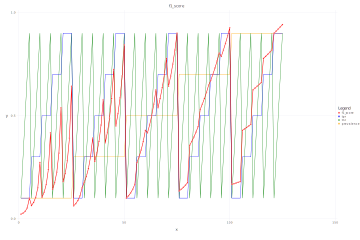

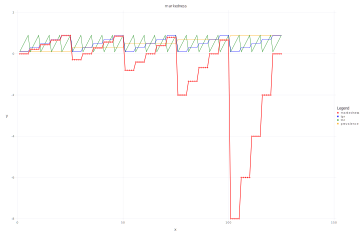

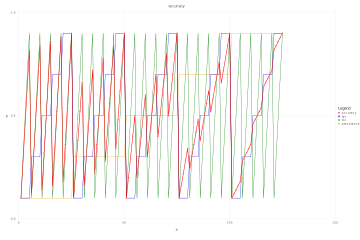

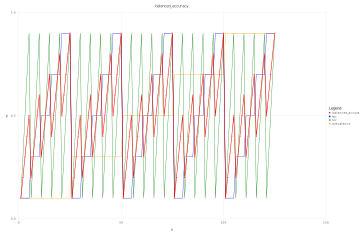

In [90]:
for m in metrics
    if m[1] !== "true_negative_rate" && m[1] !== "true_positive_rate" && m[1] !== "prevalence"
        display(plot( 
                layer(x=1:length(cms), 
                      y=m[2],
                      Geom.point, Geom.line, Theme(default_color="red", line_width=0.05cm, point_size=0.07cm)), 
                layer(x=1:length(cms), 
                      y=metrics["true_positive_rate"],  
                      Geom.line, Theme(default_color="blue", point_size=0.07cm)),
                layer(x=1:length(cms), 
                      y=metrics["true_negative_rate"],  
                      Geom.line, Theme(default_color="green", point_size=0.07cm)),
                layer(x=1:length(cms), 
                      y=metrics["prevalence"],  
                      Geom.line, Theme(default_color="orange", point_size=0.07cm)),
                Guide.manual_color_key("Legend", [m[1], "tpr", "tnr", "prevalence"], ["red", "blue", "green", "orange"]),
                Guide.title(m[1])
        ))
    end
end

## Observations
* a good metric should be the same for all values of `u` (imbalance)
* it should not have horizontal patterns (similar to true positive rate)
* it should not have diagonal patterns (similar to true negative rate)

Looking at the above plots, wee see that:

* f1-score is not really stable for imbalanced data, even if it is almost ok for slightly imbalanced data (compare $prevalence=0.4$ and $prevalence=0.6$: it keeps almost all the ordering)
* mcc is better than f1-score but has a strange behavior for highly imbalanced data ($prevalence\simeq0$, $prevalence\simeq1.0$)
* markedness looks bad
* accuracy completely changes across the imbalance levels
* informedness and balanced accuracy looks promising, let's compare them...


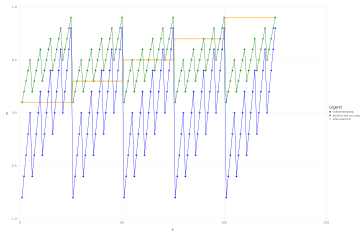

In [92]:
display(plot(
        layer(x=1:length(cms), 
              y=metrics["informedness"],  
              Geom.point, Geom.line, Theme(default_color="blue")),
        layer(x=1:length(cms), 
              y=metrics["balanced_accuracy"],  
              Geom.point, Geom.line, Theme(default_color="green")),
        layer(x=1:length(cms), 
              y=metrics["prevalence"],  
              Geom.point, Geom.line, Theme(default_color="orange", point_size=0.07cm)),
        Guide.manual_color_key(
            "Legend", ["informedness", "balanced accuracy", "prevalence"], ["blue", "green", "orange"])
))

Ok, let's fix the scale...

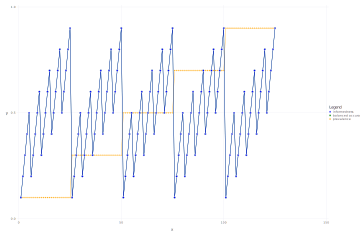

In [93]:
display(plot(
        layer(x=1:length(cms), 
              y=(metrics["informedness"] .+ 1) ./ 2,  
              Geom.point, Geom.line, Theme(default_color="blue")),
        layer(x=1:length(cms), 
              y=metrics["balanced_accuracy"],  
              Geom.point, Geom.line, Theme(default_color="green")),
        layer(x=1:length(cms), 
              y=metrics["prevalence"],  
              Geom.point, Geom.line, Theme(default_color="orange", point_size=0.07cm)),
        Guide.manual_color_key(
            "Legend", ["informedness", "balanced accuracy", "prevalence"], ["blue", "green", "orange"])
))

# Oh yes, informedness and balanced accuracy *are* the same, but in a different scale

Comparing them with MCC, we see that for highly imbalanced data, MCC is more restrictive, meaning that it is harder to identify a random guessing when data are highly imbalanced.

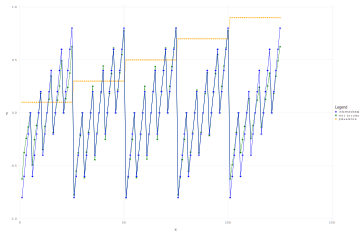

In [94]:
display(plot(
        layer(x=1:length(cms), 
              y=metrics["informedness"],  
              Geom.point, Geom.line, Theme(default_color="blue")),
        layer(x=1:length(cms), 
              y=metrics["matthews_correlation_coefficient"],  
              Geom.point, Geom.line, Theme(default_color="green")),
        layer(x=1:length(cms), 
              y=metrics["prevalence"],  
              Geom.point, Geom.line, Theme(default_color="orange", point_size=0.07cm)),
        Guide.manual_color_key(
            "Legend", ["informedness", "mcc accuracy", "prevalence"], ["blue", "green", "orange"])
))

It is interesting to look what happens for extreme prevealence values (e.g. 0.01 and 0.99)

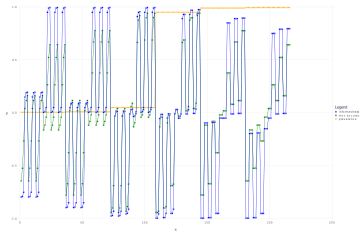

In [95]:
cms = make_cms([0.005, 0.01, 0.05, 0.95, 0.99, 0.995])
metrics = compute_metrics(cms)
display(plot(
        layer(x=1:length(cms), 
              y=metrics["informedness"],  
              Geom.point, Geom.line, Theme(default_color="blue")),
        layer(x=1:length(cms), 
              y=metrics["matthews_correlation_coefficient"],  
              Geom.point, Geom.line, Theme(default_color="green")),
        layer(x=1:length(cms), 
              y=metrics["prevalence"],  
              Geom.point, Geom.line, Theme(default_color="orange", point_size=0.07cm)),
        Guide.manual_color_key(
            "Legend", ["informedness", "mcc accuracy", "prevalence"], ["blue", "green", "orange"])
))

As you can see, both informedness and mcc tend to became step-functions for extreme values. This is not good and only means that you should avoid umbalanced data.